# Deliverable 3 - Neural Network

- **Preprocessing** (loading dataset, deature selection, standardization, conversion to tensors)


- **Model Initialization** (layer architecture, forward pass, activation function, loss, optimizer, kfold, epochs, early stopping)


- **Training** (training initialization, loss - accuracy calculation, learning rate adjustment)


- **Final Evaluation** (classification report)


- **Vizualisation** (loss and accuracy curve)

In [6]:
''' Classification of mpg of a car depending on the related features using a neural network architecture
Labels: Low, Medium, High 

Parameters: 4 layers 
Hyperparameters: neurons per layer, activation function, lr, epochs

'''
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

In [7]:
import os
nb_path = os.path.abspath('')
file_path = os.path.join(nb_path, '../../data/df_cleaned.csv')
df = pd.read_csv(file_path)

# Preprocessing

In [8]:
#seeds for reproducibility (same results in all machines)
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seeds(42)

# load dataset
data = pd.read_csv('/Users/ioannakaragianni/Desktop/WELEAD Bootcamp Project/final/final_labeled_mpg_unscaled.csv')

# features selected based on correlation - our input
features = ['horsepower', 'weight', 'displayments', 'cylinders', 'acceleration']
X = data[features]
y = data['mpg_category']  # target prediction (3 classes - Low, High, Medium labeled as 0-1-2)

# standardization of features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# converting our input and outputs to tensors so that torch can process them
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

# Model Initialization

In [9]:
# class initialization 4 layers with output layer using Tahn for the activation function
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # input from 5 features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)  # output has 3 classes
        self.tanh = nn.Tanh() #Tanh activation function

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)  # no activation on final layer
        return x

# initialization of model, loss, optimizer
model = MLP()
criterion = nn.CrossEntropyLoss() # loss we will use because cross entropy loss is used for classification tasks 
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# using k-Fold cross validation because our dataset is small
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# training parameters, ReduceLROnPlateau reduces learning rate when test loss stops improving
n_epochs = 70
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, factor=0.1)

# early stopping setup
early_stopping_patience = 7 #if no improvement on 7 consecutive epochs it stops
best_loss = float('inf')
epochs_without_improvement = 0 

/opt/homebrew/Caskroom/miniconda/base/envs/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training

In [10]:
#keeping track of loss and accuracy scores
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
# for every epoch saves the accuracies, losses and f1 scores 
for epoch in range(n_epochs):
    fold_train_accuracies = []
    fold_test_accuracies = []
    fold_train_losses = []
    fold_test_losses = []
    fold_f1_scores = []
    for train_index, test_index in kf.split(X_scaled, y):
        # spliting sets, e use indeces to keep track of the train and test sets in each of the 5 folds
        X_train, X_test = X_tensor[train_index], X_tensor[test_index]
        y_train, y_test = y_tensor[train_index], y_tensor[test_index]
        #we are wraping the sets into dataset objects and then store them in batches, also we shuffle the data
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)
        
        # actual training
        model.train()
        running_loss_train = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad() #clears previously accumulated gradients 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() #backpropagation to compute gradients through loss backwards
            optimizer.step()# applying gradient descent to update parameters
            running_loss_train += loss.item()
        train_loss = running_loss_train / len(train_loader)
        
        # evaluation of the model - test set
        model.eval()
        y_pred = []
        y_true = []
        running_loss_test = 0.0

        # here no gradient calculations bc we are only evaluating the model
        with torch.no_grad():
            for inputs, labels in test_loader:
                # forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # all test losses across the batches 
                running_loss_test += loss.item()
                # computing test accuracy
                _, predicted = torch.max(outputs, 1)
                # storing predictions for evaluation metrics
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        #evaluation metrics
        test_loss = running_loss_test / len(test_loader)
        test_accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')

        fold_train_losses.append(train_loss)
        fold_test_losses.append(test_loss)
        fold_test_accuracies.append(test_accuracy)
        fold_f1_scores.append(f1)

    # average across k folds
    mean_train_loss = np.mean(fold_train_losses)
    mean_test_loss = np.mean(fold_test_losses)
    mean_test_accuracy = np.mean(fold_test_accuracies)
    mean_f1 = np.mean(fold_f1_scores)
    # storing results for plotting
    train_losses.append(mean_train_loss)
    test_losses.append(mean_test_loss)
    test_accuracies.append(mean_test_accuracy)

    #epoch summary
    print(f"Epoch {epoch+1}: Train Loss = {mean_train_loss:.4f}, Test Loss = {mean_test_loss:.4f}, Test Acc = {mean_test_accuracy:.4f}, F1-score = {mean_f1:.4f}")

    # learning rate adjustment
    scheduler.step(mean_test_loss)

    # early stoping logic
    if mean_test_loss < best_loss:
        best_loss = mean_test_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"Epochs without improvement: {epochs_without_improvement}/{early_stopping_patience}")

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break  

Epoch 1: Train Loss = 0.6358, Test Loss = 0.6425, Test Acc = 0.7307, F1-score = 0.7156
Epoch 2: Train Loss = 0.5601, Test Loss = 0.5663, Test Acc = 0.7520, F1-score = 0.7498
Epoch 3: Train Loss = 0.5202, Test Loss = 0.5485, Test Acc = 0.7520, F1-score = 0.7479
Epoch 4: Train Loss = 0.5176, Test Loss = 0.5231, Test Acc = 0.7627, F1-score = 0.7560
Epoch 5: Train Loss = 0.4867, Test Loss = 0.5269, Test Acc = 0.7733, F1-score = 0.7721
Epochs without improvement: 1/7
Epoch 6: Train Loss = 0.4837, Test Loss = 0.4888, Test Acc = 0.7867, F1-score = 0.7849
Epoch 7: Train Loss = 0.4845, Test Loss = 0.4598, Test Acc = 0.8053, F1-score = 0.8051
Epoch 8: Train Loss = 0.4459, Test Loss = 0.4489, Test Acc = 0.8000, F1-score = 0.8004
Epoch 9: Train Loss = 0.4400, Test Loss = 0.4471, Test Acc = 0.8267, F1-score = 0.8269
Epoch 10: Train Loss = 0.4156, Test Loss = 0.4176, Test Acc = 0.8133, F1-score = 0.8125
Epoch 11: Train Loss = 0.4374, Test Loss = 0.4151, Test Acc = 0.8000, F1-score = 0.7992
Epoch 12:

# Final Evaluation

In [11]:
# evaluate on the entire dataset
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=False):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

#classification report
print("\nFinal Model Evaluation:")
print(classification_report(y_true, y_pred, target_names=['Low', 'Medium', 'High']))


Final Model Evaluation:
              precision    recall  f1-score   support

         Low       0.98      0.98      0.98       129
      Medium       0.98      0.98      0.98       127
        High       0.99      0.99      0.99       119

    accuracy                           0.98       375
   macro avg       0.98      0.98      0.98       375
weighted avg       0.98      0.98      0.98       375



# Vizualization

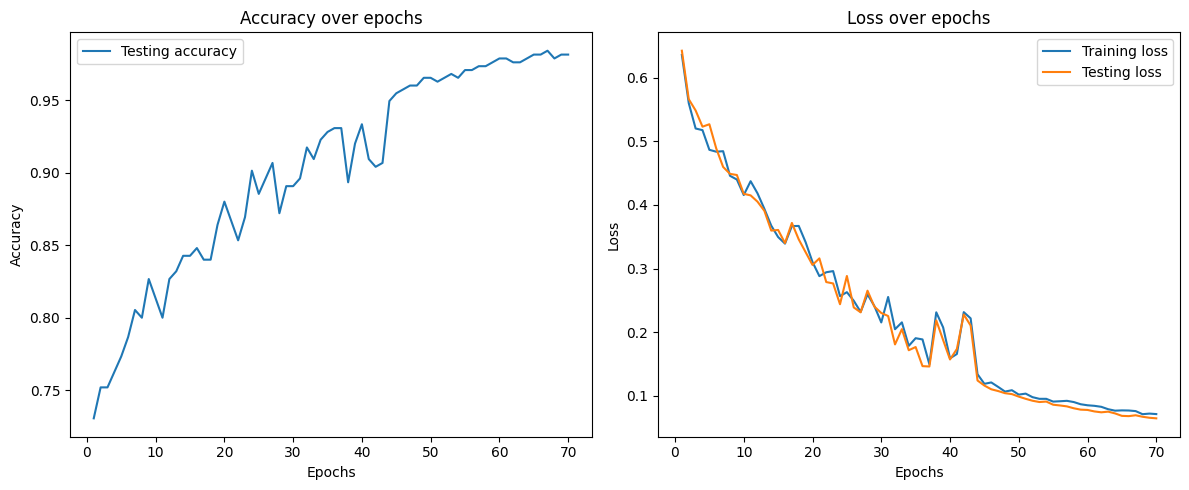

In [12]:
# visualizing 
plt.figure(figsize=(12, 5))
# accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Testing accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()